# Predicting Subscription Status of Players based on Age and Playtime #

In [1]:
set.seed(1204)
library(tidyverse)
library(tidymodels)
library(repr) # hi

players_url <- "https://raw.githubusercontent.com/aketineni/DSCI100_final_group4-31/refs/heads/main/players.csv"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### by Arnav, Kira, Riya, and Jacob ####

## Introduction ##

Our project will be looking at a dataset derived from a Minecraft server hosted by the Pacific Laboratory for Artificial Intelligence at UBC. The objective of their research is to create an AI that can operate in video games! They recorded each player's gameplay and surveyed for various characteristics of the player. 


The `players.csv` dataset contains information about 196 players and 7 variables about each player. These variables are:
1. `experience (chr)`: Describes the player's experience level as pro, veteran, regular, amateur, or beginner.
    1. There are 14 pros, 48 veterans, 36 regulars, 63 amateurs, and 35 beginners
3. `subscribe (lgl)`: Indicates if the player is subscribed or not
    1. 144 of the players were subscribed and 52 were not
5. `hashedEmail (chr)`: Contains the player's email
6. `played_hours (dbl)`: Contains how many total hours the player has played on the server
    1. The average playtime was 5.85 hrs, ranging from 0 hrs - 223.1hrs, with a median of 0.10hrs
8. `name (chr)`: Contains the player's name
9. `age (dbl)`: Contain the player's age
    1. The average age of the players was 21.14 years old, ranging from 9-58 years old, with a median of 19 years old.
11. `gender (chr)`: Contains the players gender out of the choices male, female, non-binary, agender, two-spirited, other, and prefer not to say
    1. There were 124 male, 37 female, 15 non-binary, 2 agender, and 6 two-spirited players. 11 players chose to not indicate a gender and 1 player chose other.

There are 2 NA's present in the `Age` column, which must be imputed or removed for models using age. Additionally, the `gender` column has entries with "Prefer not to say" and "Other" which complicated using gender as a predictor since these can't be imputed but don't allow those observations to be sorted into a clear category.

`played_hours` is partly determined by game mechanics, with players recieving more playtime for certain in game actions. This means that playtime is influenced by factors beyond what is represented in this data, such as their willingness to talk to others they may not know or invite friends to play with. (Playtime allotment information found at https://plaicraft.ai/rules)

In order to answer the broader question "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?", the following question can be analyzed:

Can **total playtime** and **age** predict **subscription** using the players and sessions dataset?

To answer this question, a KNN classification model using the columns `played_hours` and `age` as predictor variables and `subscription` as the response variable can be fit to the data. These variables may be able to predict subscription since they reflect the player's interest in the game, and more interested players are more likely to subscribe. Additionally, age may impact subscriptions, since younger players may not have somewhere to subscribe or may need their parents to subscribe for them.

## Methods & Results ##

### Methods and Plan ###
A KNN classification model can be used to predict the column `subscribe`, since it will use information regarding similar players to predict if new players will subscribe. There are not many assumptions (aside from locality and distance relevance) required in order to apply KNN, but the a limitation of it is that the model will be able to predict well towards the extremes of the training dataset, since it won't have reasonably close neighbors to compare to as you get farther from the training dataset. The data will be initially split into a training set with 80% of the data and a testing set with 20%. The training dataset will be further split to perform 5-fold cross validation using odd k-values between 5 and 20. The best performing k will be fit to the entire training set, and be used to compare predictions in the testing set.

### Exploratory Data Analysis and Visualization ###

In [2]:
# converted experience and gender to factor variables to more easily get counts for each option

players <- read_csv(players_url) |>
    mutate(experience = factor(experience, levels = c("Pro", "Veteran", "Regular", "Amateur", "Beginner")),
          gender = as_factor(gender), Age = as.integer(Age))

summary(players, digits = 4)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


    experience subscribe       hashedEmail         played_hours    
 Pro     :14   Mode :logical   Length:196         Min.   :  0.000  
 Veteran :48   FALSE:52        Class :character   1st Qu.:  0.000  
 Regular :36   TRUE :144       Mode  :character   Median :  0.100  
 Amateur :63                                      Mean   :  5.846  
 Beginner:35                                      3rd Qu.:  0.600  
                                                  Max.   :223.100  
                                                                   
     name                         gender         Age       
 Length:196         Male             :124   Min.   : 9.00  
 Class :character   Female           : 37   1st Qu.:17.00  
 Mode  :character   Non-binary       : 15   Median :19.00  
                    Prefer not to say: 11   Mean   :21.14  
                    Agender          :  2   3rd Qu.:22.75  
                    Two-Spirited     :  6   Max.   :58.00  
                    Other           

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In order to wrangle the `players.csv` dataset, the `experience` and the `gender` columns were converted to factor variables to simplify statistics and better reflect their data types. The data is already tidy with only one player's information in each row and only one value in each of the cells.

In [3]:
players_avgs <- players |>
    summarize(avg_played_hours = mean(played_hours), avg_age = mean(Age, na.rm = TRUE))

head(players)
players_avgs

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


avg_played_hours,avg_age
<dbl>,<dbl>
5.845918,21.13918


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


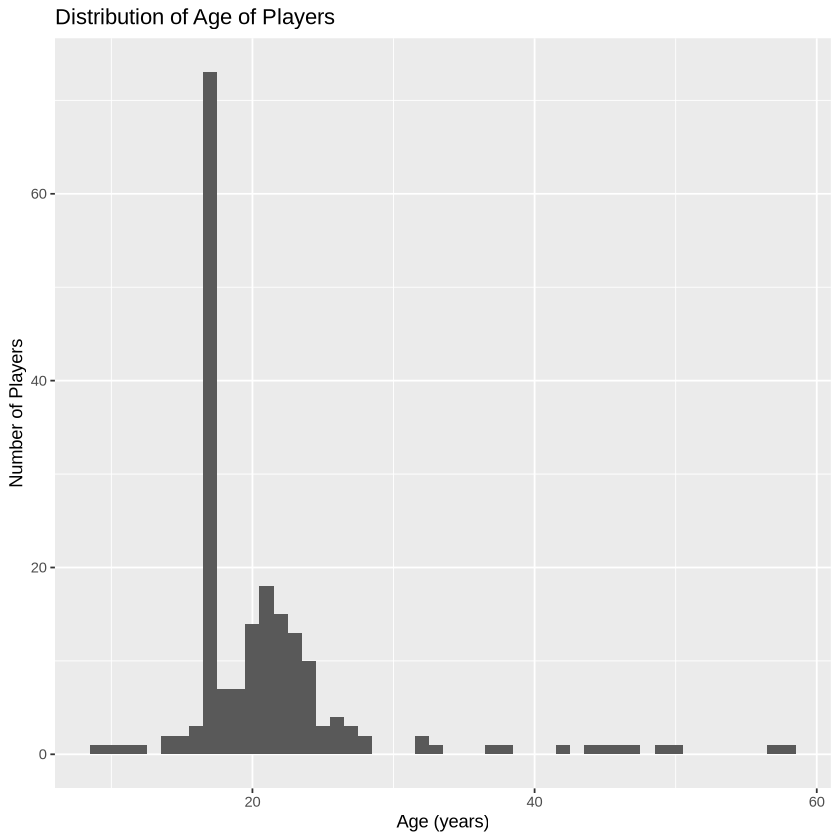

In [4]:
age_histo <- ggplot(players, aes(x = Age)) +
    geom_histogram(binwidth = 1) +
    labs(x = "Age (years)", y = "Number of Players", title = "Distribution of Age of Players")

age_histo

This histogram shows the distribution of ages among the players. It shows that almost all of the players were between 16 and 28 years old. The study is dominated by 17 year olds, with there being 3x as many 17 year olds as the next most common age. The ages range from 9 to 57 years old.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


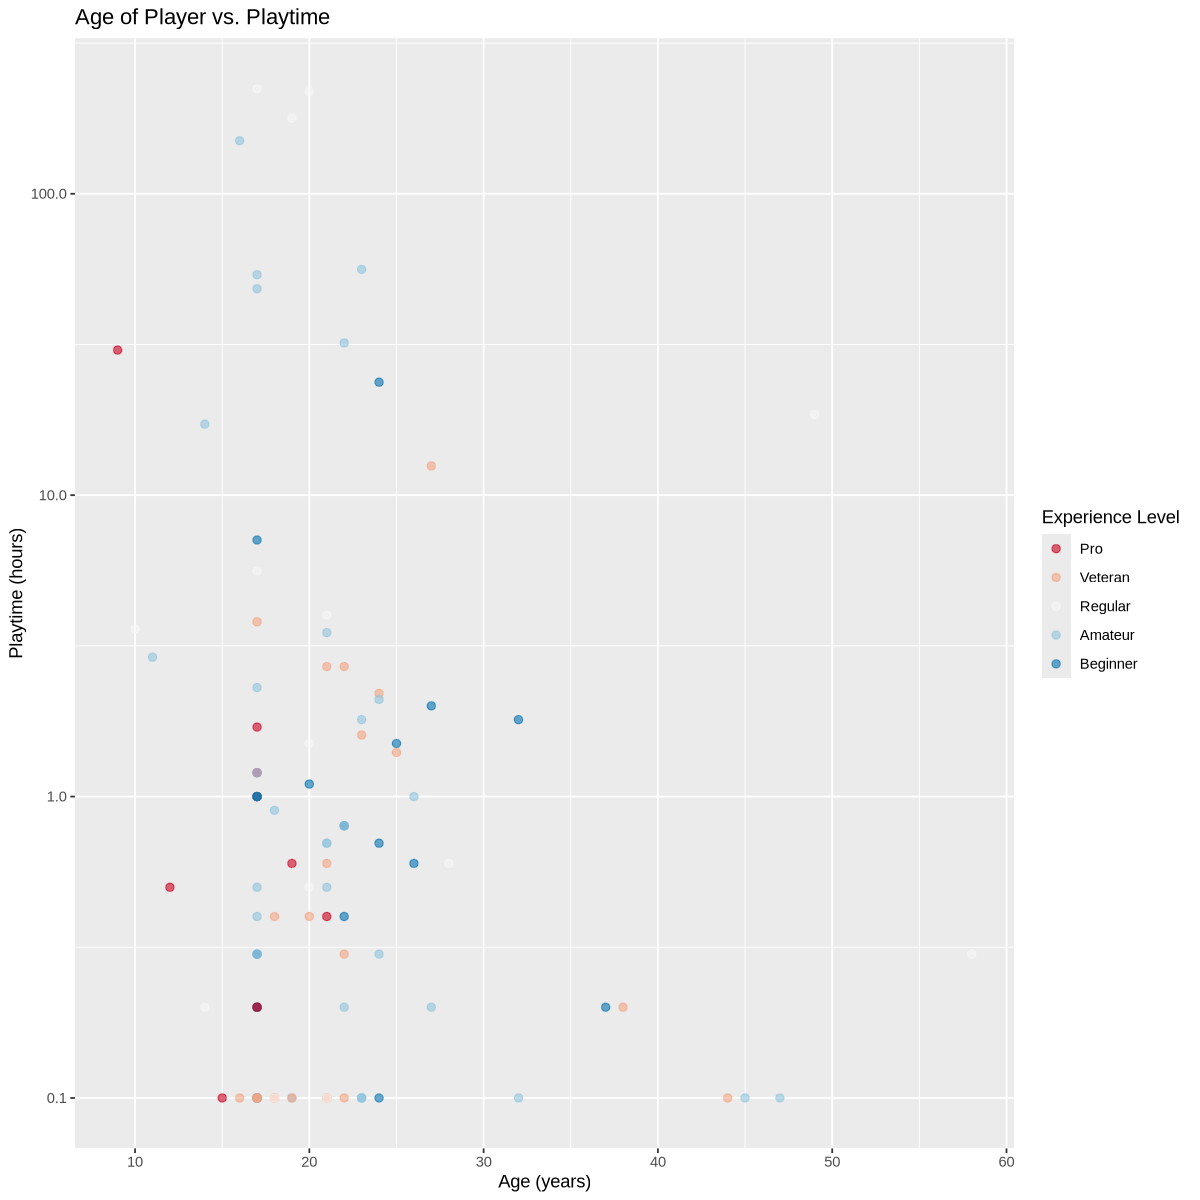

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)
hours_vs_age <- players |>
    filter(played_hours > 0) |>
    ggplot(aes(x = Age, y = played_hours, colour = experience)) +
        geom_point(alpha = 0.6, size = 2) +
        scale_y_log10() +
    labs(title = "Age of Player vs. Playtime", x = "Age (years)", y = "Playtime (hours)", colour = "Experience Level") +
    scale_color_brewer(palette = "RdBu")
hours_vs_age

This scatter plot shows the relationship between age and how many hours the person has played. It also separates the players based on their experience level. According to the plot, there is no obvious relationship between the age and played hours, and experience doesn't seem to impact how long people play or how old their are.

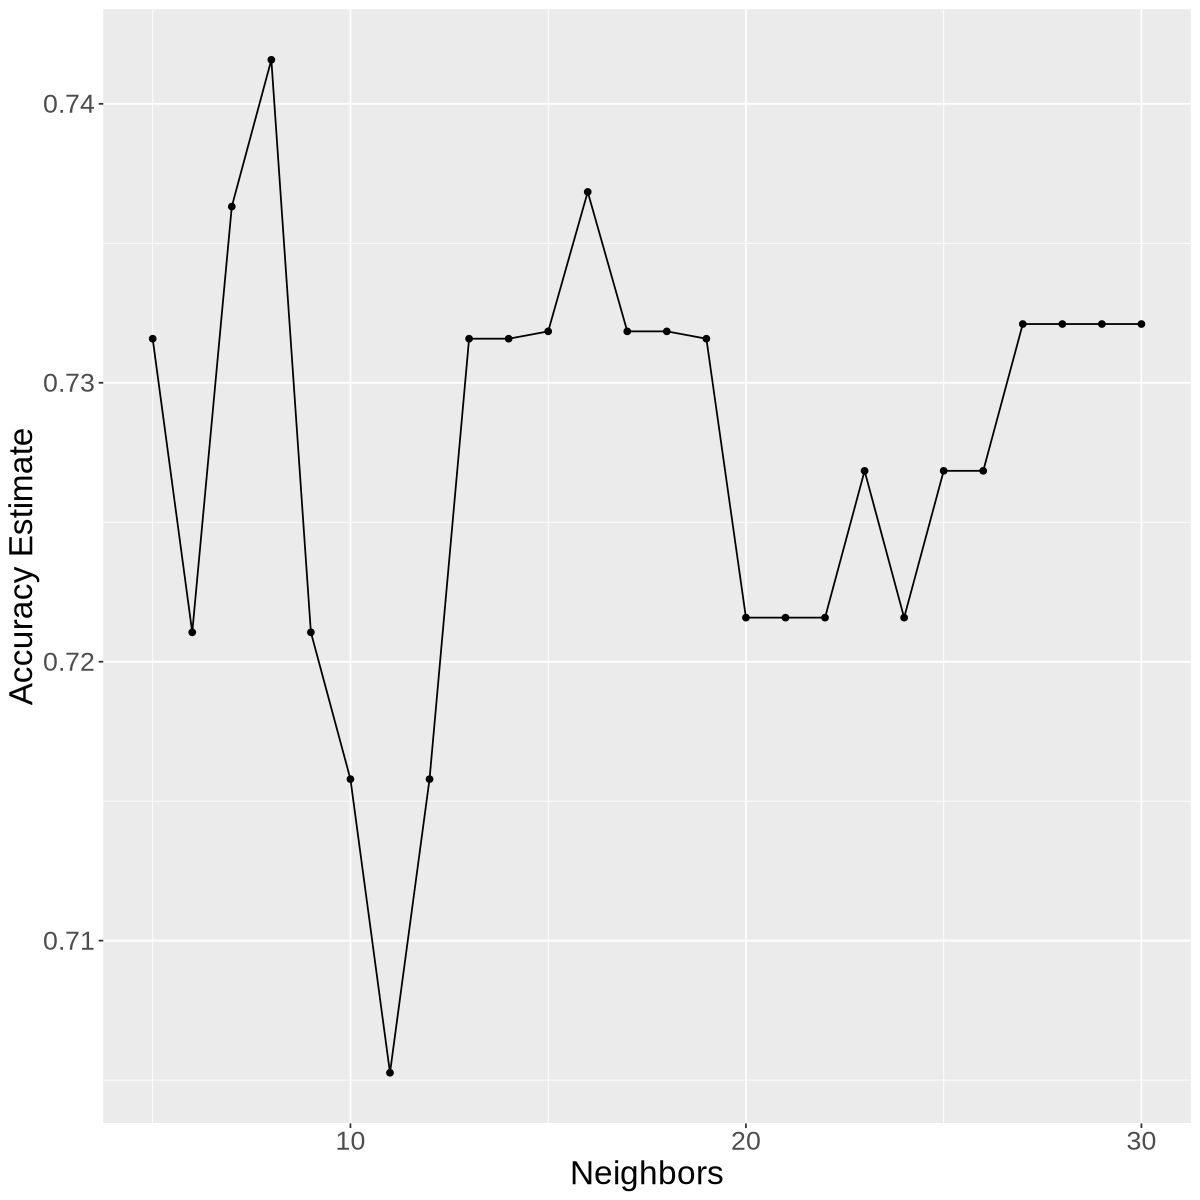

In [6]:
players_knn <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != "NA")

players_split <- initial_split(players_knn, prop = 0.8, strata = subscribe)

players_training <- training(players_split)

players_testing <- testing(players_split)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_testing)

players_vfold <- vfold_cv(players_knn, v = 5, strata = subscribe)

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = tibble(neighbors = 5:30)) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == 'accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = 'Neighbors', y = 'Accuracy Estimate') +
    theme(text = element_text(size = 20))

cross_val_plot

In [7]:
best_k <- accuracies |>
    slice_max(mean, n = 1)|>
    pull(neighbors)

players_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_model(players_spec_final) |>
    add_recipe(players_recipe) |>
    fit(players_training) 

players_predictions <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)

metrics(players_predictions, truth = subscribe, estimate = .pred_class) # yes :)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7000000
kap,binary,0.2476489


In [9]:
age_grid <- seq(min(players$Age),
                max(players$Age),
                length.out = 100)
hours_grid <- seq(min(players$played_hours),
                max(players$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Area = age_grid,
                                Smoothness = hours_grid))

# use the fit workflow to make predictions at the grid points
playersPredGrid <- predict(players_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(playersPredGrid, asgrid) |>
  rename(Class = .pred_class)

player_pred_plot <-
  ggplot() +
  geom_point(data = players,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = subscribe),
             alpha = 0.75) +
  geom_point(data = players_predictions,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = Class),
             alpha = 0.02,
             size = 5) +
  labs(color = "Subscription Status",
       x = "Age (years)",
       y = "Playtime (hours)") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

player_pred_plot

ERROR: Error in seq.default(min(players$Age), max(players$Age), length.out = 100): 'from' must be a finite number


## Discussion ##

We

### Github Repository ###
https://github.com/aketineni/DSCI100_final_planning

## References ##
https://plaicraft.ai/faq/ethics